In [1]:
import nibabel as nib
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

## Read the dataset 

In [2]:
import os
import nibabel as nib
import matplotlib.pyplot as plt

# 폴더 경로 설정
base_path = "/workspace/eli"
folders = {
    "train": "01_training",
    "val": "02_validation",
    "test": "03_test"
}

# 다양한 파일 이름 패턴 목록 (이미지와 마스크 파일 분리)
possible_image_patterns = [
    "{patient_number}_CT-ax.nii.gz",
    "{patient_number}.nii.gz",
    "{patient_number}_CT-iso.nii.gz"
]

possible_mask_patterns = [
    "{patient_number}_CT-ax_seg.nii.gz",
    "{patient_number}_seg.nii.gz",
    "{patient_number}_CT-iso_seg.nii.gz"
]

# 각 폴더에서 환자 데이터를 불러오는 함수
def load_nii_files(data_type):
    image_arrays = []
    mask_arrays = []
    
    folder_path = os.path.join(base_path, folders[data_type])
    
    # 환자 번호 폴더 목록 가져오기
    patients_numbers = os.listdir(folder_path)
    
    for patient_number in patients_numbers:
        image_path = None
        mask_path = None
        
        # 이미지 파일 경로 찾기
        for img_pattern in possible_image_patterns:
            temp_image_path = os.path.join(folder_path, patient_number, img_pattern.format(patient_number=patient_number))
            
            if os.path.exists(temp_image_path):
                image_path = temp_image_path
                break
        
        # 마스크 파일 경로 찾기
        for mask_pattern in possible_mask_patterns:
            temp_mask_path = os.path.join(folder_path, patient_number, mask_pattern.format(patient_number=patient_number))
            
            if os.path.exists(temp_mask_path):
                mask_path = temp_mask_path
                break
        
        # 경로 출력 및 Nii 파일 로드
        if image_path and mask_path:
            print(f"Loading image: {image_path}")
            print(f"Loading mask: {mask_path}")
            
            image = nib.load(image_path).get_fdata()
            mask = nib.load(mask_path).get_fdata()
            
            image_arrays.append(image)
            mask_arrays.append(mask)
        else:
            print(f"Warning: Missing files for patient {patient_number}")
    
    return image_arrays, mask_arrays

# 트레이닝, 검증, 테스트 데이터 불러오기
train_image_array, train_mask_array = load_nii_files("train")
val_image_array, val_mask_array = load_nii_files("val")
test_image_array, test_mask_array = load_nii_files("test")

Loading image: /workspace/eli/01_training/verse825/verse825_CT-iso.nii.gz
Loading mask: /workspace/eli/01_training/verse825/verse825_CT-iso_seg.nii.gz
Loading image: /workspace/eli/01_training/verse091/verse091.nii.gz
Loading mask: /workspace/eli/01_training/verse091/verse091_seg.nii.gz
Loading image: /workspace/eli/01_training/verse097/verse097.nii.gz
Loading mask: /workspace/eli/01_training/verse097/verse097_seg.nii.gz
Loading image: /workspace/eli/01_training/verse586/verse586_CT-iso.nii.gz
Loading mask: /workspace/eli/01_training/verse586/verse586_CT-iso_seg.nii.gz
Loading image: /workspace/eli/01_training/GL003/GL003.nii.gz
Loading mask: /workspace/eli/01_training/GL003/GL003_seg.nii.gz
Loading image: /workspace/eli/01_training/verse539/verse539_CT-iso.nii.gz
Loading mask: /workspace/eli/01_training/verse539/verse539_CT-iso_seg.nii.gz
Loading image: /workspace/eli/01_training/verse544/verse544.nii.gz
Loading mask: /workspace/eli/01_training/verse544/verse544_seg.nii.gz
Loading ima

## There isn't any problem in data reading

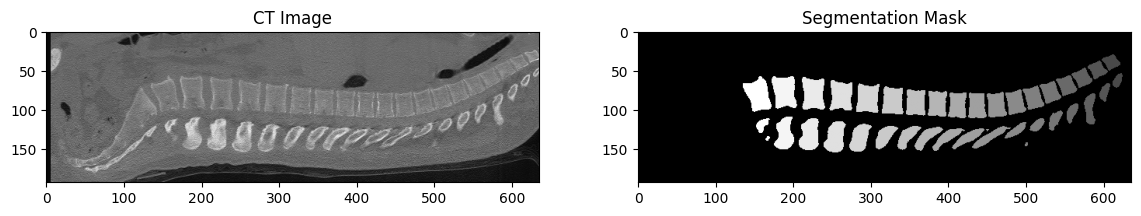

In [3]:
# 배열 시각화 (첫 번째 이미지와 마스크)
if train_image_array and train_mask_array:
    idx = len(train_image_array) // 2  # 중간 인덱스의 이미지를 사용
    
    # 중간 섹션 선택 (슬라이스를 선택하기 위해 축 설정)
    slice_idx = train_image_array[idx].shape[2] // 2  # z축 기준 중간
    
    img = train_image_array[idx][:, :, slice_idx]
    mask = train_mask_array[idx][:, :, slice_idx]

    fig, arr = plt.subplots(1, 2, figsize=(14, 10))

    # Image 시각화
    arr[0].imshow(img, cmap="gray")
    arr[0].set_title('CT Image')
    arr[0].set_aspect('equal')  # 1:1 비율 설정

    # Mask 시각화
    arr[1].imshow(mask, cmap="gray")
    arr[1].set_title('Segmentation Mask')
    arr[1].set_aspect('equal')  # 1:1 비율 설정

    plt.show()

else:
    print("No image or mask data available.")

In [4]:
print(train_image_array)
print(val_image_array)
print(test_image_array)

[array([[[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],

       [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],

       [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-1

In [5]:
'''import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class MedicalDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # 필요시 numpy 배열을 tensor로 변환하고 차원 추가
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, Depth, Height, Width)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # (1, Depth, Height, Width)

        # 이미지와 마스크를 224x224x181로 리사이즈 (3D interpolate 사용)
        image = F.interpolate(image.unsqueeze(0), size=(64, 64, image.shape[2]), mode='trilinear', align_corners=True).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=(64, 64, mask.shape[2]), mode='trilinear', align_corners=True).squeeze(0)

        return image, mask

# 데이터셋 생성
train_dataset = MedicalDataset([train_image_array], [train_mask_array])
val_dataset = MedicalDataset([val_image_array], [val_mask_array])
test_dataset = MedicalDataset([test_image_array], [test_mask_array])

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 확인용 출력
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break  # 첫 배치만 확인'''
    
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class MedicalDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # 필요시 numpy 배열을 tensor로 변환하고 차원 추가 (1, Depth, Height, Width)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, Depth, Height, Width)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # (1, Depth, Height, Width)

        # 이미지와 마스크를 64x64x64로 리사이즈 (3D interpolate 사용)
        image = F.interpolate(image.unsqueeze(0), size=(64, 64, 64), mode='trilinear', align_corners=True).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=(64, 64, 64), mode='trilinear', align_corners=True).squeeze(0)

        return image, mask

# 데이터셋 생성
train_dataset = MedicalDataset(train_image_array, train_mask_array)
val_dataset = MedicalDataset(val_image_array, val_mask_array)
test_dataset = MedicalDataset(test_image_array, test_mask_array)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 확인용 출력
for images, masks in train_loader:
    print("Image shape:", images.shape)
    print("Mask shape:", masks.shape)
    break  # 첫 배치만 확인


Image shape: torch.Size([1, 1, 64, 64, 64])
Mask shape: torch.Size([1, 1, 64, 64, 64])


In [6]:
# 예제: DataLoader에서 배치 확인
for batch in train_loader:
    images, masks = batch  # 이미지와 마스크 분리
    print("Batch Images Shape:", images.shape)  # (배치 크기, 채널 수, 깊이, 높이, 너비)
    print("Batch Masks Shape:", masks.shape)    # (배치 크기, 채널 수, 깊이, 높이, 너비)
    break  # 첫 배치만 확인

Batch Images Shape: torch.Size([1, 1, 64, 64, 64])
Batch Masks Shape: torch.Size([1, 1, 64, 64, 64])


In [7]:
'''import torch
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv_block(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv_block(512, 256)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv_block(256, 128)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv_block(128, 64)
        self.decoder1 = self.conv_block(128, 64)

        # Final convolution to get the desired output channels
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool3d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool3d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool3d(2)(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool3d(2)(enc4))

        # Decoding path with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Concatenate along channel axis
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Final 1x1 convolution to get the output
        return self.final_conv(dec1)

# Model initialization with desired input and output channels
model = UNet3D(in_channels=1, out_channels=1)  # Example: single channel input and output'''

'import torch\nimport torch.nn as nn\n\nclass UNet3D(nn.Module):\n    def __init__(self, in_channels, out_channels):\n        super(UNet3D, self).__init__()\n        # Encoder\n        self.encoder1 = self.conv_block(in_channels, 64)\n        self.encoder2 = self.conv_block(64, 128)\n        self.encoder3 = self.conv_block(128, 256)\n        self.encoder4 = self.conv_block(256, 512)\n\n        # Bottleneck\n        self.bottleneck = self.conv_block(512, 1024)\n\n        # Decoder\n        self.upconv4 = self.upconv_block(1024, 512)\n        self.decoder4 = self.conv_block(1024, 512)\n\n        self.upconv3 = self.upconv_block(512, 256)\n        self.decoder3 = self.conv_block(512, 256)\n\n        self.upconv2 = self.upconv_block(256, 128)\n        self.decoder2 = self.conv_block(256, 128)\n\n        self.upconv1 = self.upconv_block(128, 64)\n        self.decoder1 = self.conv_block(128, 64)\n\n        # Final convolution to get the desired output channels\n        self.final_conv = nn.C

In [8]:
import torch
import torch.nn as nn

class UNet3Dplus(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3Dplus, self).__init__()
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = self.upconv_block(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv_block(512, 256)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv_block(256, 128)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv_block(128, 64)
        self.decoder1 = self.conv_block(128, 64)

        # Final convolution to get the desired output channels
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(nn.MaxPool3d(2)(enc1))
        enc3 = self.encoder3(nn.MaxPool3d(2)(enc2))
        enc4 = self.encoder4(nn.MaxPool3d(2)(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool3d(2)(enc4))

        # Decoding path with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = self.crop_and_concat(dec4, enc4)  # Concatenate along channel axis
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = self.crop_and_concat(dec3, enc3)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self.crop_and_concat(dec2, enc2)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self.crop_and_concat(dec1, enc1)
        dec1 = self.decoder1(dec1)

        # Final 1x1 convolution to get the output
        return self.final_conv(dec1)

    def crop_and_concat(self, upconv_output, encoder_output):
        """
        Crop the encoder output and concatenate it with the up-conv output.
        """
        # Crop the encoder output to match the size of the up-conv output
        diff_z = encoder_output.size(2) - upconv_output.size(2)
        diff_y = encoder_output.size(3) - upconv_output.size(3)
        diff_x = encoder_output.size(4) - upconv_output.size(4)

        # Crop the encoder output
        encoder_output_cropped = encoder_output[:, :, 
            diff_z // 2: encoder_output.size(2) - diff_z // 2,
            diff_y // 2: encoder_output.size(3) - diff_y // 2,
            diff_x // 2: encoder_output.size(4) - diff_x // 2]

        # Concatenate along the channel dimension
        return torch.cat((upconv_output, encoder_output_cropped), dim=1)

# Model initialization with desired input and output channels
model = UNet3Dplus(in_channels=1, out_channels=1)  # Example: single channel input and output


In [10]:
def iou(preds, targets, smooth=1e-6):
    preds = preds > 0.5  # 이진 분류를 위한 임계값
    targets = targets > 0.5
    intersection = (preds & targets).float().sum((1, 2, 3))  # 각 배치의 교집합
    union = (preds | targets).float().sum((1, 2, 3))  # 각 배치의 합집합
    iou_score = (intersection + smooth) / (union + smooth)  # IoU 계산
    return iou_score.mean()  # 평균 IoU 반환

def dice_loss(preds, targets, smooth=1e-6):
    preds = preds.sigmoid()  # sigmoid로 이진 분류 확률값으로 변환
    targets = targets > 0.5  # 마스크를 이진화

    intersection = (preds * targets).sum(dim=(1, 2, 3, 4))
    dice = (2. * intersection + smooth) / (preds.sum(dim=(1, 2, 3, 4)) + targets.sum(dim=(1, 2, 3, 4)) + smooth)

    return 1 - dice.mean()

import torch.optim as optim

# Hyperparameters
num_epochs = 1000  # Number of epochs to train
learning_rate = 1e-6  # Learning rate
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

# Move model to device
model = model.to(device)

# Loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_one_epoch(train_loader, model, optimizer):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for images, masks in train_loader:
        # Move data to the selected device
        images, masks = images.to(device), masks.to(device)

        # GPU 메모리 정리
        torch.cuda.empty_cache()  # 이 위치에서 GPU 메모리 정리

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = dice_loss(outputs, masks)
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

    return total_loss / len(train_loader)

# Validation function
def validate_one_epoch(val_loader, model):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_iou = 0.0

    with torch.no_grad():  # Disable gradient tracking
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # GPU 메모리 정리
            torch.cuda.empty_cache()  # 이 위치에서 GPU 메모리 정리

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = dice_loss(outputs, masks)
            total_loss += loss.item()

            # Calculate IoU
            iou_score = iou(outputs, masks)
            total_iou += iou_score.item()

    return total_loss / len(val_loader), total_iou / len(val_loader)

# Training loop with model saving
best_val_loss = float('inf')  # To track the best validation loss

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader, model, optimizer)
    val_loss, val_iou = validate_one_epoch(val_loader, model)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation IoU: {val_iou:.4f}')

    # Save the model if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'unet3dplus_best_epoch.pth')
        print(f"Model saved at epoch {epoch + 1} with validation loss {val_loss:.4f}")

Epoch 1/1000, Train Loss: 0.9234, Validation Loss: 0.9319, Validation IoU: 0.0675
Model saved at epoch 1 with validation loss 0.9319
Epoch 2/1000, Train Loss: 0.8811, Validation Loss: 0.9046, Validation IoU: 0.1002
Model saved at epoch 2 with validation loss 0.9046
Epoch 3/1000, Train Loss: 0.8412, Validation Loss: 0.8607, Validation IoU: 0.1385
Model saved at epoch 3 with validation loss 0.8607
Epoch 4/1000, Train Loss: 0.7672, Validation Loss: 0.7991, Validation IoU: 0.1636
Model saved at epoch 4 with validation loss 0.7991
Epoch 5/1000, Train Loss: 0.7257, Validation Loss: 0.7737, Validation IoU: 0.1805
Model saved at epoch 5 with validation loss 0.7737
Epoch 6/1000, Train Loss: 0.7038, Validation Loss: 0.7466, Validation IoU: 0.1859
Model saved at epoch 6 with validation loss 0.7466
Epoch 7/1000, Train Loss: 0.6648, Validation Loss: 0.6620, Validation IoU: 0.2237
Model saved at epoch 7 with validation loss 0.6620
Epoch 8/1000, Train Loss: 0.5867, Validation Loss: 0.5692, Validation